In [125]:
import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

import findspark
findspark.init()

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [126]:
import pyspark
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

# import get_ref_info.py
import os
import sys
my_fun = '../src/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *
from operator import add
from urllib.parse import urlparse
import seaborn as sns

# Loading data 

**File schema** is shown.

In [96]:
DATA_DIR = '../' 
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
# show file schema
wikipedia.printSchema()

root
 |-- id: long (nullable = true)
 |-- ns: long (nullable = true)
 |-- restrictions: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nulla

---

# Article outliers removal

We have some outliers we need to deal with, as a first step we use keywords (riot, war, conflict, protest) on the article titles to extract from our chosen categories (`civilian attack`, `civil conflict`, `military conflict`).

For example, we found that some articles in `civilian attack` may contain the infobox `civilian attack` but are not really a `civilian attack`. The following page 

> Fraunces Tavern: Fraunces Tavern is a landmark museum and restaurant in New York City, situated at 54 Pearl Street at the corner of Broad Street. The location played a prominent role in history before, during and after the American Revolution, serving as a headquarters for George Washington, a venue for peace negotiations with the British, and housing federal offices in the Early Republic.

Since some pages are considered **outliers**, we remove them using the method described above.


---
# Quantifying *importance* of each page in each category

We want to see how *important* each page is in each category. As we are solely focusing on *'war'*-related subjects in this pilot phase, we define *page importance* by the number of deaths. 

## Infobox or Wikidata per category 

Functions `get_wiki_civilian_attack`, `get_wiki_military_conflict`
to get relevant information and views for each category: `civilian attack`, `military conflict`. 
Data is obtained either using the page's wikidata is the data exists or acquired through infobox parsing.
Relevant information is chosen based on the fields found on [List of infoboxes and fields](https://en.wikipedia.org/wiki/Wikipedia:List_of_infoboxes#Event) 

Extract info for each category in **Infobox**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * place
    * date 
    * casualities1
* `civil conflict`
    * place
    * date 
    * casualities1
    
Extract info for each category in **Wikidata**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
* `civil conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
    
We use an external library [wptools wiki](https://github.com/siznax/wptools/wiki) to help us parse the data. 

### Categories
We focus on categories : `civilian attack`, `military conflict`, `civil conflict` from our pre-filtered wikipedia dump data which had 3 categories: `civilian attack`, `military conflict`, `civil conflict` (key words we used via regex expression to extract articles containing infoboxes with such headers by parsing the revision.text.__VALUE). 

We also found a list of all ongoing civil wars listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars) have a `Template:Infobox military`. This may be of interest in a later step.

[List of ongoing civil wars](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars):
 * Myanmar, Internal conflict in Myanmar, since 1948
 * Indonesia, Papua conflict, since 1962
 * Colombia, Colombian conflict, since 1964
 * Afghanistan, War in Afghanistan, since 1978
 * Turkey, Kurdish–Turkish conflict since 1978
 * Somalia, Somali Civil War, since 1988
 * Sudan, three conflicts
* War in Darfur, since 26 February 2003
* Sudanese nomadic conflicts, since 26 May 2009 through at least 2017
* Sudanese conflict in South Kordofan and Blue Nile since 5 June 2011
 * Pakistan, War in North-West Pakistan, since 16 March 2004
 * Paraguay, Paraguayan People's Army insurgency, since 2005
 * Syria, Syrian Civil War, since 15 March 2011, also see List of armed groups in the Syrian Civil War
 * Central African Republic, Central African Republic conflict, since 10 December 2012
 * South Sudan, South Sudanese Civil War, since 15 December 2013
 * Libya, Second Libyan Civil War, since 16 May 2014
 * Yemen, Second Yemeni Civil War, since 19 March 2015

In [120]:
def get_wiki_military_conflict(entity):
    page = wptools.page(entity.title)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            page.get_parse()
            info['death'] = poly_page.data['infobox']['casualties1']
        except:
            info['death'] = None
            
    try:
        page.get_wikidata()
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            page.get_parse()
            info['end_date'] = poly_page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        page.get_wikidata()
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            page.get_parse()
            info['location'] = poly_page.data['infobox']['place']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, title=entity.title, death=info['death'],
               end_date=info['end_date'], location=info['location'])

### Wikidata & Infobox `military conflict `

In [88]:
infobox_military_conflict = 'military conflict'
# find all pages that have category military conflict
wiki_military_conflict = wikipedia.where("categories like '%{}%'".format(infobox_military_conflict)) 

In [89]:
wiki_military_conflict_df = sqlContext.createDataFrame(wiki_military_conflict.rdd.map(get_wiki_military_conflict))

In [94]:
wiki_military_conflict_df.take(3)

[Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''Civilian dead:'''\n* Over 45,000,000\n* '''Total dead:'''\n* Over 61,000,000\n* (1937–1945)\n* [[World War II casualties|...''further details'']]}}", end_date='{{ubl|start and end dates|1939|9|1|1945|9|2|df|=|yes|\n                  |(|Age in years and days|1 September 1939|2 September 1945|sep|=|and|)|efn| While [[World War II#Chronology|various other dates]] have been proposed as the date on which World War II began or ended, this is the time span most frequently cited.}} {{start and end dates|1939|9|1|1945|9|2|df|=|yes}} {{Age in years and days|1 September 1939|2 September 1945|sep|=|and}} ) {{efn| While [[World War II#Chronology|various other dates]] have been proposed as the date on which World War II began or ended, this is the time span most frequently cited.}}', id=655845, location='Athens (Q3292481)', title='Battle of Athens (1946)'),
 Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n*

In [ ]:
# saving binary file to future uses
wiki_military_conflict_df.write.parquet(DATA_DIR +"{}.parquet".format(infobox_military_conflict));
# loading the saved parquet files
wiki_military_conflict_df_reload = spark.read.parquet(
    DATA_DIR_FILTERED+"{}.parquet".format(infobox_military_conflict));

### Wikidata & Infobox `civilian attack`

In [107]:
def get_wiki_civilian_attack(entity):
    page = wptools.page(entity.title)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            page.get_parse()
            info['death'] = poly_page.data['infobox']['fatalities']
        except:
            info['death'] = None
            
    try:
        page.get_wikidata()
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            page.get_parse()
            info['end_date'] = poly_page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        page.get_wikidata()
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            page.get_parse()
            info['location'] = poly_page.data['infobox']['location']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, title=entity.title, death=info['death'],
               end_date=info['end_date'], location=info['location'])

In [108]:
infobox_civilian_attack = 'civilian attack'
# find all pages that have category civilian attack
wiki_civilian_attack = wikipedia.where("categories like '%{}%'".format(infobox_civilian_attack)) 

In [109]:
wiki_civilian_attack_df = sqlContext.createDataFrame(wiki_civilian_attack.rdd.map(get_wiki_civilian_attack))

In [110]:
wiki_civilian_attack_df.take(3)

[Row(death='6', end_date='{{start date and age|1993|02|26}}', id=676659, location='Pereira (Q51111)', title='Rwandan genocide'),
 Row(death='6', end_date='{{start date and age|1993|02|26}}', id=683450, location='Zarqa (Q148062)', title="Dawson's Field hijackings"),
 Row(death='6', end_date='{{start date and age|1993|02|26}}', id=690570, location='Manhattan (Q11299)', title='Fraunces Tavern')]

### Wikidata & Infobox `civil conflict`

In [112]:
infobox_civil_conflict = 'civil conflict'
# find all pages that have category civilian attack
wiki_civil_conflict = wikipedia.where("categories like '%{}%'".format(infobox_civil_conflict)) 

In [121]:
wiki_civil_conflict_df = sqlContext.createDataFrame(wiki_civil_conflict.rdd.map(get_wiki_military_conflict))

In [122]:
wiki_civil_conflict_df.take(3)

[Row(death=None, end_date='11, 12 and 13 September 2000', id=661864, location='[[Melbourne]], [[Australia]]', title='S11 (protest)'),
 Row(death=None, end_date='11, 12 and 13 September 2000', id=664490, location='[[Melbourne]], [[Australia]]', title='1912 Lawrence textile strike'),
 Row(death=None, end_date='11, 12 and 13 September 2000', id=1613199, location='[[Melbourne]], [[Australia]]', title='East St. Louis Race Riots')]

---

# Popularity Metrics

## Loading the data

In [123]:
# Loading the data
DATA_DIR = '../' 
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia_ref = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
wikipedia_ref.show(10)

+------+---+------------+--------------------+--------------------+-----------------+---------------+
|    id| ns|restrictions|            revision|               title|       categories|good_categories|
+------+---+------------+--------------------+--------------------+-----------------+---------------+
|655845|  0|        null|[, [,, 5175837,, ...|Battle of Athens ...|military conflict|           true|
|656035|  0|        null|[[link,], [,, 268...|  Battle of Calabria|military conflict|           true|
|656087|  0|        null|[, [,,, 96.77.37....|   Italo-Turkish War|military conflict|           true|
|656173|  0|        null|[[Formatting.,], ...|Third Anglo-Afgha...|military conflict|           true|
|656175|  0|        null|[[/* 1879 */The B...|Second Anglo-Afgh...|military conflict|           true|
|656473|  0|        null|[[Moved images.,]...|   Illinois campaign|military conflict|           true|
|659156|  0|        null|[, [,, 29980587,,...|Battle of Kock (1...|military confli

## POPULARITY METRIC 1

### Get number of references per page

We use our pre-filtered data and we count the number of tag of type ```<ref>```, by parsing all pages to get the number of references. We think that the more *popular* a page is, the more references it will contain.

We want to see:
* how many references a page has
* what does the distribution of the references look like 
* what are the top domains across these articles 
* how many articles have a reference to each domain

The analysis is based on work from *Research:Characterizing Wikipedia Citation Usage*: [MetaPageQueries](https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis)

Example of reference format:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```

**quantify the number of references per page**
    * using regex expression to find the references in the page
    * counting the number of references

In [127]:
# quantify the number of references per page

# Compile a regular expression pattern into a regular expression object, 
#which can be used for matching using its findall.
just_ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

# find # references <ref> per page 
def get_refs_count(entity, regex_expression=just_ref_regex ):
    # get access to value in text in revision
    text = entity.revision.text._VALUE
    # find references
    refs = just_ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs), categories=entity.categories)

In [128]:
# get the # of references per page
# Creates a DataFrame from an RDD, apply counting function with regex expression
reference_count_page = sqlContext.createDataFrame(wikipedia_ref.rdd.map(get_refs_count))
reference_count_page.sort('refs_count', ascending=False).show(5)
reference_count_page_sql = reference_count_page.registerTempTable('reference_count_page_sql')

+-----------------+--------+----------+
|       categories|      id|refs_count|
+-----------------+--------+----------+
|military conflict|52019122|      1000|
|military conflict|46230181|       818|
|military conflict|42563745|       734|
|military conflict|43243199|       609|
|military conflict|     771|       598|
+-----------------+--------+----------+
only showing top 5 rows



In [129]:
# quantify the # articles with # ref > 0: 
non_zero_ref_query = """
select count(DISTINCT id)
from reference_count_page_sql
where refs_count > 0
"""
non_zero_articles = spark.sql(non_zero_ref_query)

non_zero_articles_pd = non_zero_articles.toPandas().iloc[0,0]
print("Number of articles with #references > 0: " + str(non_zero_articles_pd))

Number of articles with #references > 0: 15986


**Distribution of number of references** We bin the number of references to get the number of pages having at least x #references. This is observed with a histogram plot.

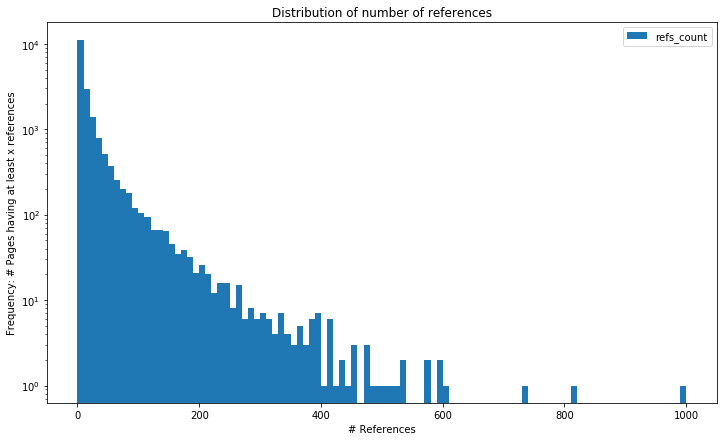

In [130]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, log=True, figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references')
plt.show()

**Distribution of number of references**: It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many references have at least x pages?

The distribution has a heavy-tailed distribution: they may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If they follow a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

### Get the domains of references

In [131]:
references_rrd = wikipedia.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(5)

+------+---------+--------------------+--------------------+
|    id| template|               title|                 url|
+------+---------+--------------------+--------------------+
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845| cite web|The Battle of Athens|http://www.americ...|
+------+---------+--------------------+--------------------+
only showing top 5 rows



**URL parsing** 
Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [132]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('books.google.com', 10226),
 ('www.nytimes.com', 4304),
 ('www.reuters.com', 3759),
 ('www.almasdarnews.com', 3397),
 ('www.theguardian.com', 3365),
 ('www.bbc.co.uk', 2872),
 ('news.bbc.co.uk', 2354),
 ('www.washingtonpost.com', 2026),
 ('www.aljazeera.com', 1997),
 ('www.bbc.com', 1993),
 ('www.cnn.com', 1639),
 ('www.telegraph.co.uk', 1540),
 ('www.syriahr.com', 1518),
 ('edition.cnn.com', 1193),
 ('www.independent.co.uk', 993),
 ('abcnews.go.com', 894),
 ('twitter.com', 814),
 ('www.foxnews.com', 722),
 ('www.haaretz.com', 712),
 ('www.jpost.com', 684),
 ('www.dawn.com', 684),
 ('www.dailystar.com.lb', 682),
 ('www.cbsnews.com', 654),
 ('news.yahoo.com', 647),
 ('www.youtube.com', 642),
 ('www.wsj.com', 634),
 ('archive.org', 606),
 ('www.latimes.com', 604),
 ('www.huffingtonpost.com', 603),
 ('www.usatoday.com', 585)]

In [133]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 166810


In [134]:
def percentage(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]*100/number_links)

domains_distribution = sqlContext.createDataFrame(domains_count.map(percentage)).sort("count", ascending=False)
domains_distribution.show()

+-----+--------------------+-------------------+
|count|              domain|               perc|
+-----+--------------------+-------------------+
|10226|    books.google.com|  6.130327917990528|
| 4304|     www.nytimes.com| 2.5801810443019004|
| 3759|     www.reuters.com|  2.253462022660512|
| 3397|www.almasdarnews.com| 2.0364486541574247|
| 3365| www.theguardian.com| 2.0172651519693066|
| 2872|       www.bbc.co.uk| 1.7217193213836102|
| 2354|      news.bbc.co.uk| 1.4111863797134465|
| 2026|www.washingtonpos...| 1.2145554822852347|
| 1997|   www.aljazeera.com| 1.1971704334272526|
| 1993|         www.bbc.com| 1.1947724956537378|
| 1639|         www.cnn.com|   0.98255500269768|
| 1540| www.telegraph.co.uk| 0.9232060428031893|
| 1518|     www.syriahr.com|  0.910017385048858|
| 1193|     edition.cnn.com| 0.7151849409507823|
|  993|www.independent.c...| 0.5952880522750434|
|  894|      abcnews.go.com| 0.5359390923805527|
|  814|         twitter.com|0.48798033691025716|
|  722|     www.foxn

In [135]:
domains_distribution_pd = domains_distribution.toPandas().set_index('domain')

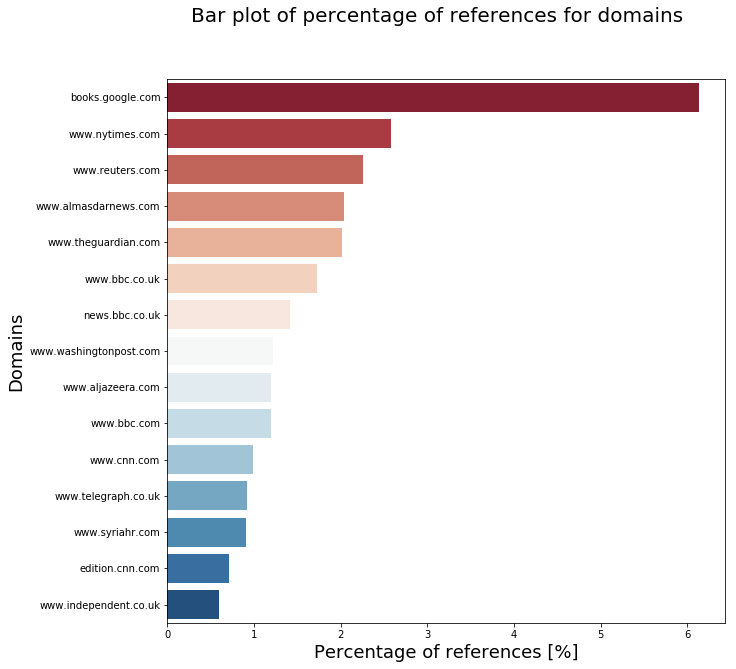

In [136]:
domains_distribution_pd20 = domains_distribution_pd.head(15)
import seaborn as sns
# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd20['perc'], domains_distribution_pd20.index, palette="RdBu", ax=ax1, orient='h')
plt.xlabel('Percentage of references [%]',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of percentage of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

# ===== TO DELETE ========

In [ ]:
infobox_civil_attack = 'civilian attack'
# find all pages that have category civilian attack
wiki_civil_attack = wikipedia.where("categories like '%{}%'".format(infobox_civil_attack)) 
# show file schema
wiki_civil_attack.printSchema()

In [ ]:
wiki_civil_attack.filter("title like '%Fraunces Tavern%'").select("categories").collect()

In [ ]:
wiki_civil_attack_df = sqlContext.createDataFrame(wiki_civil_attack.rdd.map(get_infobox_civilian_attack))

In [ ]:
wiki_civil_attack_df.take(3)

In [ ]:
# GET INFO FROM INFOBOX + VIEWS for different categories
def get_infobox_civilian_attack(entity):
    # get page
    page = wptools.page(entity.title)
    page.get_parse()
    page.get_more()
    # extract relevant information and put in dictionary
    info = {'views': None, 'location': None, 
            'date': None, 'fatalities': None, 'injuries': None }
    try:
        info['views'] = page.data['views']
    except KeyError:
        info['views'] = None
    
    for ele in list(info.keys())[1:]:
        try:
            info[ele] = page.data['infobox'][ele]
        except KeyError:
            pass
    
    return Row(id=entity.id, title=entity.title, location=info['location'], views=info['views'], date=info['date'], 
                fatalities=info['fatalities'], injuries=info['injuries'])

def get_infobox_civil_conflict(entity):
    # get page
    page = wptools.page(entity.title)
    page.get_parse()
    page.get_more()
    # extract relevant information and put in dictionary
    info = {'views': None, 'place': None, 'injuries': None,
            'date': None, 'fatalities': None, 'casualties1': None, 'casualties2': None,
            'leadfigures1': None, 'leadfigures2': None} 
    try:
        info['views'] = page.data['views']
    except KeyError:
        info['views'] = None
    
    for ele in list(info.keys())[1:]:
        try:
            info[ele] = page.data['infobox'][ele]
        except KeyError:
            pass
    
    return Row(id=entity.id, title=entity.title, location=info['place'], views=info['views'], date=info['date'], 
               fatalities=info['fatalities'], casualties1=info['casualties1'], casualties2=info['casualties2'],
               injuries=info['injuries'], leadfigures1=info['leadfigures1'], leadfigures2=info['leadfigures2'])

def get_infobox_military_conflict(entity):
    # get page
    page = wptools.page(entity.title)
    page.get_parse()
    page.get_more()
    # extract relevant information and put in dictionary
    info = {'views': None, 'place': None, 
            'date': None, 'casualties1': None, 'casualties2': None}#, 'status': None}
            #'combatant1': None, 'combatant2': None, 'status': None} 
    try:
        info['views'] = page.data['views']
    except KeyError:
        info['views'] = None
    
    for ele in list(info.keys())[1:]:
        try:
            info[ele] = page.data['infobox'][ele]
        except KeyError:
            pass
    
    return Row(id=entity.id, title=entity.title, location=info['place'], views=info['views'], date=info['date'], 
               casualties1=info['casualties1'], casualties2=info['casualties2']) #, status=info['status'])
               #combatant1=info['combatant1'], combatant2=info['combatant2'])

In [ ]:
DATA_DIR_FILTERED = '../clean_data/'

In [ ]:
# saving binary file to future uses
wiki_civil_attack_df.write.parquet(DATA_DIR_FILTERED+"{}.parquet".format(infobox_civil_attack));
# loading the saved parquet files
wiki_civil_attack_df_reload = spark.read.parquet(DATA_DIR_FILTERED+"{}.parquet".format(infobox_civil_attack));

In [ ]:
wiki_civil_attack_df = sqlContext.createDataFrame(wiki_civil_attack_RDD)

### Infobox `civil conflict`

In [ ]:
infobox_civil_conflict = 'civil conflict'
# find all pages that have category civil conflict
wiki_civil_conflict = wikipedia.where("categories like '%{}%'".format(infobox_civil_conflict)) 
# show file schema
wiki_civil_conflict.printSchema()

In [ ]:
wiki_civil_conflict_df = sqlContext.createDataFrame(wiki_civil_conflict.rdd.map(get_infobox_civil_conflict))

In [ ]:
wiki_civil_conflict_df.take(3)

In [ ]:
# saving binary file to future uses
wiki_civil_conflict_df.write.parquet(DATA_DIR_FILTERED+"{}.parquet".format(infobox_civil_conflict));
# loading the saved parquet files
wiki_civil_conflict_df_reload = spark.read.parquet(DATA_DIR_FILTERED+"{}.parquet".format(infobox_civil_conflict));

### Infobox `military conflict `

In [ ]:
infobox_military_conflict = 'military conflict'
# find all pages that have category military conflict
wiki_military_conflict = wikipedia.where("categories like '%{}%'".format(infobox_military_conflict)) 
# show file schema
wiki_military_conflict.printSchema()

In [ ]:
wiki_military_conflict_df = sqlContext.createDataFrame(wiki_military_conflict.rdd.map(get_infobox_military_conflict))

In [ ]:
wiki_military_conflict_df.take(3)

In [ ]:
# saving binary file to future uses
wiki_military_conflict_df.write.parquet(DATA_DIR_FILTERED+"{}.parquet".format(infobox_military_conflict));
# loading the saved parquet files
wiki_military_conflict_df_reload = spark.read.parquet(
    DATA_DIR_FILTERED+"{}.parquet".format(infobox_military_conflict));

### Functions

In [79]:
def get_wiki_military_conflict(entity):
    page = wptools.page(entity.title)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except KeyError:
        try:
            page.get_parse()
            info['death'] = poly_page.data['infobox']['casualties1']
        except KeyError:
            info['death'] = None
            
    try:
        page.get_wikidata()
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except KeyError:
        try:
            page.get_parse()
            info['end_date'] = poly_page.data['infobox']['date']
        except KeyError:
            info['end_date'] = None
    
    try:
        page.get_wikidata()
        info['location'] = page.data['wikidata']['location (P276)']
    except KeyError:
        try:
            page.get_parse()
            info['location'] = poly_page.data['infobox']['place']
        except KeyError:
            info['location'] = None
    
    
    return Row(id=entity.id, title=entity.title, death=info['death'],
               end_date=info['end_date'], location=info['location']) #, location=info['location'])    


### UNICORN ON THE GOOO

In [117]:
## trying access to infobox
poly_page = wptools.page('S11 (protest)')
poly_page.get_parse()
poly_page.get_wikidata()

en.wikipedia.org (parse) S11 (protest)
S11 (protest) (en) data
{
  infobox: <dict(5)> title, partof, date, place, methods
  pageid: 661864
  parsetree: <str(11557)> <root><template><title>Use dmy dates</ti...
  requests: <list(1)> parse
  title: S11 (protest)
  wikibase: Q7388176
  wikidata_url: https://www.wikidata.org/wiki/Q7388176
  wikitext: <str(9319)> {{Use dmy dates|date=October 2011}}{{Use A...
}
www.wikidata.org (wikidata) Q7388176
www.wikidata.org (labels) Q408|P17
Note: Wikidata item Q7388176 missing 'instance of' (P31)
S11 (protest) (en) data
{
  claims: <dict(1)> P17
  description: protest against globalization
  infobox: <dict(5)> title, partof, date, place, methods
  label: S11
  labels: <dict(2)> Q408, P17
  modified: <dict(1)> wikidata
  pageid: 661864
  parsetree: <str(11557)> <root><template><title>Use dmy dates</ti...
  requests: <list(3)> parse, wikidata, labels
  title: S11_(protest)
  wikibase: Q7388176
  wikidata: <dict(1)> country (P17)
  wikidata_pageid: 72973

In [118]:
poly_page.data['infobox']

{'title': 'S11',
 'partof': '[[anti-globalisation movement]]',
 'date': '11, 12 and 13 September 2000',
 'place': '[[Melbourne]], [[Australia]]',
 'methods': 'Protests'}

In [119]:
poly_page.data['wikidata']

{'country (P17)': 'Australia (Q408)'}

In [116]:
ww2 = wikipedia.filter("title like '%World War II%'") #World War II for military, civilian attack 1993 World Trade Center bombing
ww2_df = sqlContext.createDataFrame(ww2.rdd.map(get_wiki_military_conflict))

ValueError: Some of types cannot be determined by the first 100 rows, please try again with sampling

In [81]:
ww2_df.show(2)

+--------------------+--------------------+------+---------------+--------------------+
|               death|            end_date|    id|       location|               title|
+--------------------+--------------------+------+---------------+--------------------+
|{{plainlist|
* ''...|+1945-02-15T00:00...| 64692|Dresden (Q1731)|Bombing of Dresde...|
|{{plainlist|
* ''...|+1941-06-01T00:00...|627326| Albania (Q222)|Balkans Campaign ...|
+--------------------+--------------------+------+---------------+--------------------+
only showing top 2 rows



In [82]:
ww2_df.select('location').collect()

[Row(location='Dresden (Q1731)'),
 Row(location='Albania (Q222)'),
 Row(location='[Russia (Q159), Europe (Q46), Africa (Q15), Pacific Ocean (Q98), Mediterranean Sea (Q4918), Asia (Q48), Atlantic Ocean (Q97), Middle East (Q7204), Southeast Asia (Q11708), Scandinavia (Q21195)]'),
 Row(location='Mediterranean Sea (Q4918)'),
 Row(location='Lienz (Q336250)'),
 Row(location='Malta Colony (Q6744657)'),
 Row(location='East Africa (Q27407)'),
 Row(location='[Norwegian Sea (Q47545), Arctic Ocean (Q788)]'),
 Row(location='State of Burma (Q704358)'),
 Row(location='Europe (Q46)'),
 Row(location='Vienna (Q1741)'),
 Row(location='Königsberg (Q4120832)'),
 Row(location='Warsaw (Q270)'),
 Row(location='Berlin (Q64)'),
 Row(location='[[European theatre of World War II|Europe]], [[Pacific War|Pacific]], [[Battle of the Atlantic|Atlantic]], [[South-East Asian theatre of World War II|South-East Asia]], [[Second Sino-Japanese War|China]], [[Mediterranean and Middle East theatre of World War II|Middle East]

In [83]:
ww2_df.select('end_date').collect()

[Row(end_date='+1945-02-15T00:00:00Z'),
 Row(end_date='+1941-06-01T00:00:00Z'),
 Row(end_date='+1945-09-02T00:00:00Z'),
 Row(end_date='{{ubl|start and end dates|1939|9|1|1945|9|2|df|=|yes|\n                  |(|Age in years and days|1 September 1939|2 September 1945|sep|=|and|)|efn| While [[World War II#Chronology|various other dates]] have been proposed as the date on which World War II began or ended, this is the time span most frequently cited.}} {{start and end dates|1939|9|1|1945|9|2|df|=|yes}} {{Age in years and days|1 September 1939|2 September 1945|sep|=|and}} ) {{efn| While [[World War II#Chronology|various other dates]] have been proposed as the date on which World War II began or ended, this is the time span most frequently cited.}}'),
 Row(end_date='{{ubl|start and end dates|1939|9|1|1945|9|2|df|=|yes|\n                  |(|Age in years and days|1 September 1939|2 September 1945|sep|=|and|)|efn| While [[World War II#Chronology|various other dates]] have been proposed as the

In [43]:
ww2_df.select('title').collect()

[Row(title='Bombing of Dresden in World War II'),
 Row(title='Balkans Campaign (World War II)'),
 Row(title='World War II'),
 Row(title='Mediterranean U-boat Campaign (World War II)'),
 Row(title='Repatriation of Cossacks after World War II'),
 Row(title='Siege of Malta (World War II)'),
 Row(title='East African Campaign (World War II)'),
 Row(title='Arctic convoys of World War II'),
 Row(title='South-East Asian theatre of World War II'),
 Row(title='European theatre of World War II'),
 Row(title='Bombing of Vienna in World War II'),
 Row(title='Bombing of Königsberg in World War II'),
 Row(title='Bombing of Warsaw in World War II'),
 Row(title='Bombing of Berlin in World War II'),
 Row(title='Polish resistance movement in World War II'),
 Row(title='Mediterranean and Middle East theatre of World War II'),
 Row(title='Eastern Front (World War II)'),
 Row(title='Western Front (World War II)'),
 Row(title='Strategic bombing during World War II'),
 Row(title='Italian Campaign (World War I

In [44]:
ww2_df.select('death').collect()

[Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''Civilian dead:'''\n* Over 45,000,000\n* '''Total dead:'''\n* Over 61,000,000\n* (1937–1945)\n* [[World War II casualties|...''further details'']]}}"),
 Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''Civilian dead:'''\n* Over 45,000,000\n* '''Total dead:'''\n* Over 61,000,000\n* (1937–1945)\n* [[World War II casualties|...''further details'']]}}"),
 Row(death='+73000000'),
 Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''Civilian dead:'''\n* Over 45,000,000\n* '''Total dead:'''\n* Over 61,000,000\n* (1937–1945)\n* [[World War II casualties|...''further details'']]}}"),
 Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''Civilian dead:'''\n* Over 45,000,000\n* '''Total dead:'''\n* Over 61,000,000\n* (1937–1945)\n* [[World War II casualties|...''further details'']]}}"),
 Row(death="{{plainlist|\n* '''Military dead:'''\n* Over 16,000,000\n* '''C

In [45]:
ww2_df.select('id').collect()

[Row(id=64692),
 Row(id=627326),
 Row(id=32927),
 Row(id=8027546),
 Row(id=3498598),
 Row(id=776074),
 Row(id=988219),
 Row(id=998807),
 Row(id=902040),
 Row(id=342640),
 Row(id=7439614),
 Row(id=7468801),
 Row(id=927764),
 Row(id=936661),
 Row(id=4329310),
 Row(id=1779568),
 Row(id=519489),
 Row(id=519516),
 Row(id=730658),
 Row(id=493696),
 Row(id=5352468),
 Row(id=4149594),
 Row(id=54639200),
 Row(id=52997544),
 Row(id=7668163),
 Row(id=7148715),
 Row(id=11413940),
 Row(id=13669170),
 Row(id=8814971),
 Row(id=20537542),
 Row(id=6820802),
 Row(id=54956721),
 Row(id=537817),
 Row(id=22573476),
 Row(id=22619466),
 Row(id=22752221),
 Row(id=22878403),
 Row(id=25536548),
 Row(id=291341),
 Row(id=2728998),
 Row(id=10805870),
 Row(id=33247384),
 Row(id=32732761),
 Row(id=15873865),
 Row(id=2823356),
 Row(id=10262809),
 Row(id=4397117),
 Row(id=30281564),
 Row(id=30319330),
 Row(id=17426585),
 Row(id=36240634),
 Row(id=27495752)]